# 🚶‍♂️ The Validation, by walking in the forward

The "*walk forward - validation*" is the *technique* that will let us fit the model **which has generalized** the overall pattern in the data and is not *overfitted*.

> But... we do have train-test-split right?

## The problems

## 1️⃣
Till now, I have used the old school `ttsplit` technique to do the work... but that **again** *("again" because that same problem rises in the common ML scenario)* creates problems because we are only partitionling the data in `2` parts and while testing, with the test data, we *tune the model* by ourselves — and hence the testing data becomes the "in-sample" data ie. the model might not have been generalized yet — only optimized for the training and testing data.

## 2️⃣
The solution was **to use the Cross-Validation**. The shiny, glittering, jargon, used by professors and paper readers term: "Cross. Vali. Dation."

Yeah, I mean literally this technique is like, when I read this... I've got it! But when it comes in different context... *I might wanna re-check it once*. Coming back to the problems: Can we use the Cross validation in the time series setting?

> Of course... not!

**Why?** <br>
The reason is — the CV split *"kind of randomized data"*. While the time-series being a sequential data, ***we can't actually let it randomize it***. Consider this → 1, 2, 3, 4, 5 are the months in 2022. For 1st CV it will use 2, 3, 4, 5 as training and 1 for valucation. Fine, but then it will use 1, 3, 4, 5 and 2 for validation. There is a gap man!

And also, the data points inside can be randomized as well!

<img src="../images/no-nooo.gif" hight=300 width=200>

Okay got it... but what is the freakin' solution? How can I save my model not to **mug up** the data?

### 

## 📝 The WalkForward Validation
*Notice, there is no "CROSS"*.

<img src="../images/walk-forward-validation.png" height=300 width=500>

- We will start with *some minimum* amount of data.
- Then we will forecast the `h` points.
- That means: we will only take `h` sized validation set.
- Then we will move some `offest` step ahead and repeat the same *(offset say, 1)*.
- This will continue **till we reach to end** of the data.


    `data`: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
    `h`: 3
    
    Step 1 — `train-set`: 1 | `validation-set`: 2, 3, 4
    Step 1.1 — Train → forecast `h` and validate 
    Step 2 — `train-set`: 1, 2 | `validation-set`: 3, 4, 5
    .
    .
    .
    Step n - hth: — `train-set`: 1, 2, 3, 4, 5, 6, 7, 8 | `validation-set`: 9, 10, 11
    (here 8th)

😊 માજા આવી?

###### 

### And ausaau <a href="https://dictionary.cambridge.org/media/english/uk_pron/u/uka/ukall/ukally_030.mp3"> 🔊 </a>
We can choose whether or not to take "full data" or not. Meaning, if in our case the data relies more on the recent past data, and we also want the *recent* data to be in the training... ***and instead of growing*** the data continuously by some `offset` term... we can keep the **datasize *constant***.

*(you might want to click on the speaker)*

<img src="../images/fix-window.png" height=300 width=500>

### It is ausaau <a href="https://dictionary.cambridge.org/media/english/uk_pron/u/uka/ukall/ukally_030.mp3"> 🔊 </a> possible to walk `h` steps
Meaning, the "bigger" jumps!

<img src="../images/h-steps.png" height=300 width=500>

- This *might* require you to manually calculate the `offset` size which **evenly** divides the data

# 

# 💺 Tighten Your Seats
We are going to code it!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv("../data/airline_passengers.csv",
                 index_col=0,
                 parse_dates=True)

df.index.freq = "MS"

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 🔎 An Overview
See, that this is *a kind of* cross validation technique. So, here instead of ***learning*** a new model technique... we will simply use the latest learned model *(Holt Winter's)* and use the **WalkForward** to **hypertune** the good parameters.

The parameters will be chosen on the basis of: "whichever giving the smallest error". Thus, there will be an error function.

**Overview** is:
1. We will see how to "**walk**" — how to partition the data.
2. Create a **function** which will help us **to walk** through data — with validation chunks.
3. Create **another function** which will **call the previous** function to test all combinations of the input *(Grid search)*.

In [4]:
# Total indices
len(df.index)

144

- Means we can set the horision `h` as 12. That means: **we will be able to forecast 12 points in the future and validate at the same time**. 
- Then we will set the `offset` to 1. Which is common.

Keep this image in mind ↓ <br>
<img src="../images/walk-forward-validation.png" height=300 width=500>

Just a handy calculation... 

1. `144` data points are **there in total**.
2. Initially we will take `100` points, keeping `12` points **for validation**.
    - Hence, in first iteration we will be using `112` data-points only *(leaving `32` for later use)* .
3. Then, with `100` points, we will **train** and with `12` points we will **validate**.
4. **Store the error** in the list.
5. **Update** the training size: to `101` and hence we will be using `113` data-points now.*(leaving `31` for later use)*  .
6. We will **repeat** steps 3, 4, 5 until no data-points are remaining in the data.
7. This process will take exactly 33 steps *(loops to complete)* or ***33 folds*** (because the 1st fold will be counted).

Let's verify them.

In [5]:
# Just the simple parameters for our validation
h = 12
offset = 1

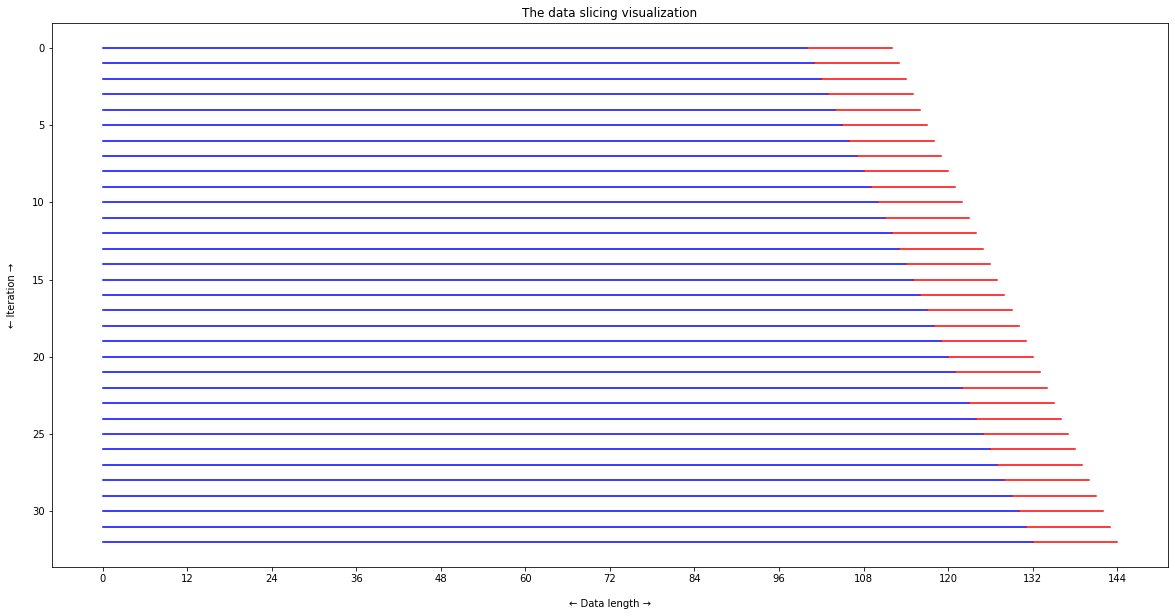

In [6]:
axes = plt.axes()

for th, idx in enumerate(range(100, len(df) + 1 - h, offset)):
    axes.plot([0, idx], [th, th], color="blue", label="Training")
    axes.plot([idx, idx + h], [th, th], color="red", label="Validation")

    
axes.invert_yaxis()
axes.set_xticks(range(0, 145, 12))
axes.set_title("The data slicing visualization")
axes.set_xlabel("← Data length →", labelpad=15)
axes.set_ylabel("← Iteration →", labelpad=15);

In [7]:
print("Total iterations were: ", th + 1)

Total iterations were:  33


**Note:** That the *blue* represents the training data, and *red* represents the validation data.

The line: `len(df) + 1 - h, offset` should not confuse you.
- `len(df)` lets us set *till when*.
- `+1` lets us use the last point as well *(because if 0 index based programming!)*.
- `h` lets use set the we should only go 144 - 12. Otherwise we would empty whole dataset *(even taking the last 12 point and leavning with nothing in last 12 runs for validation)*

###### 

### ⚒ Making a function to do stuff

In [8]:
df = df.Passengers

In [9]:
def walkforward(
    trend_type,
    season_type,
    init_method,
    use_boxcox,
    debug=False):
    
    """
    This function should be called either individually or from the 
    grid search (the manual one).
    
    What is does is, it will fit and validate the model sotring the 
    errors of each fold in the errors list.
    
    Returns the mean of errors.
    """
    errors = []
    for th, idx in enumerate(range(100, len(df) + 1 - h, offset)):
        # Two simple parts
        train = df.iloc[:idx]
        test = df.iloc[idx:idx+h]
        
        # The model initialization of the parameters 
        model = ExponentialSmoothing(train, 
                                    trend=trend_type,
                                    seasonal=season_type,
                                    initialization_method=init_method,
                                    use_boxcox=use_boxcox,
                                    seasonal_periods=12)
        # Learning
        result = model.fit()
        
        # Getting the forecast results
        forecast = result.forecast(h)
        
        # Storing the error
        error = mean_absolute_percentage_error(test, forecast)
        errors.append(error)
        
    if debug:
        print("Total", th + 1, "steps!")
            
    return np.mean(errors) * 100

In [10]:
walkforward("add", "mul", "estimated", True, True)

Total 33 steps!


5.220419866050618

So, whith *those* parameters we are getting the `5.22%` error on an everage. Which can be said as a good as of now.

Let's try implementing the Grid Search!

In [11]:
from itertools import product

In [12]:
some_list = \
[
    ["A", "Y"],
    ["1", "2"],
    ["^", "#", "$"],
]

In [13]:
for i in product(*some_list):
    print(i)

('A', '1', '^')
('A', '1', '#')
('A', '1', '$')
('A', '2', '^')
('A', '2', '#')
('A', '2', '$')
('Y', '1', '^')
('Y', '1', '#')
('Y', '1', '$')
('Y', '2', '^')
('Y', '2', '#')
('Y', '2', '$')


Thus, see that we are able to get all combinations *(not permutations!)* of the items provided. Just that will be used as our logic!

In [14]:
list_of_parameters = \
[
    ["add", "mul"],
    ["add", "mul"],
    ["estimated", "heuristic", "legacy-heuristic"],
    [True, False]
]

In [15]:
# Total possible combinations
2 * 2 * 3 * 2

24

In [16]:
def gridSearch(list_of_parameters):
    best_score = float('inf') # NEW!
    best_hyperparams = None
    
    for th, parameters in enumerate(product(*list_of_parameters)):
        print(th + 1, "/24", sep="")
        score = walkforward(*parameters)
        
        if score < best_score:
            best_score = score
            best_hyperparams = parameters
            
    return best_score, best_hyperparams

In [141]:
gridSearch(list_of_parameters)

1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24


(4.232775520177539, ('add', 'mul', 'legacy-heuristic', False))

Total: `24 * 33 = 792` fits!

### Bro!!
We have done it! The grid search is done!

# How was it?
Next up, we will **practice** on another dataset! See you there!